# Workshop: Building an AI Medical Diagnosis Agent

Welcome! In this workshop, we'll build a smart AI Agent that can:

1.  **Chat with a user** to understand their symptoms.
2.  **Decide** when it has gathered enough information to move to research.
3.  **Use external tools** (like Perplexity's API) to narrow down medical conditions.
4.  **Analyze the findings** and the conversation.
5.  **Generate a structured report.**

Think of it like a simplified version of a preliminary medical consultation (but **IMPORTANT DISCLAIMER:** this is for educational purposes ONLY and is NOT a substitute for real medical advice (yet)!).

**Why is this interesting?**

* **LLMs as Orchestrators:** We'll see how Large Language Models (LLMs) like Google's Gemini can evolve beyond only generating text and also *control a workflow*, make decisions, and use tools.
* **LangChain & LangGraph:** We'll use these powerful libraries designed to make building complex AI applications easier. LangGraph helps create reliable, step-by-step AI processes through state management.
* **Real-world Pattern:** Similar patterns to this one (chat -> gather info -> use tools -> synthesize) are common in many professions, and can be leveraged to automate real jobs.

**Today's Goal:** Understand the components and logic needed to create this agent and run it interactively. Learn

**Prerequisites:** Gemini and Perplexity API. We'll explain the AI concepts as we go!

Let's draw the basic flow in our notebooks:
[User Input] -> [Chatbot Conversation] -> [Research Step] -> [Analysis Step] -> [Final Report]

## Step 1: Import libraries we'll be using in the workshop

In [ ]:
# ---- Core Python & Utilities ---- #
import os
import sys
import time # used for rate-limiting
import requests # for making web requests to Perplexity API
from functools import wraps # Helper used for building decorators easily
from typing import List, Dict, Any # For type hinting
from typing_extensions import Annotated, TypedDict # For advanced type for our state
# ---- Langchain & LangGraph ---- #
from operator import itemgetter
import google.api_core.exceptions # for handling google API errors
from google.generativeai import configure, list_models #
!pip install langchain-google-genai # installs the LangChain Integration for google's models quietly
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.tools import tool
from langchain_core.prompts import PromptTemplate
!pip install langgraph # installs the LangGraph library quietly
from langgraph.graph import StateGraph, START, END # Core components for building the graph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

## Set up the APIs to use LLMs for the agent

In [ ]:
from google.colab import userdata # a secure way to access keys in colab we've saved as secrets
!pip install -U langchain langsmith httpx
GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')
PERPLEXITY_API_KEY = userdata.get('PERPLEXITY_API_KEY')

## Set up a function for API rate-limiting so the API use does not burn a hole in your wallet or get denied. We will also be giving Perplexity API as a tool to Gemini LLM to invoke, so there's a chance of infinite loops.

In [ ]:
def api_rate_limit(seconds: int = 2): # default pause is 2 seconds
    """This nested function creates and returns a Decorator to add sleep time between API calls"""
    def decorator(func):
        @wraps(func) # Saves the metadata of wrapped function (like name, docstring) to
        def wrapper(*args, **kwargs):
        """This wrapper executes the following code before the target function executes"""
            time.sleep(seconds)  # Pause for some seconds before making the API call
            return func(*args, **kwargs) # Now calls the original target function
        return wrapper
    return decorator

## Turning Perplexity API into a tool that Learn-lm-1.5-pro can use to deepen its analysis

In [ ]:
@tool # LangChain decorator. Now the function for Perplexity API is available as a tool for the LLM
@api_rate_limit(1) # Apply our custom 1-second rate limit before calling this function each time
def perplexity_research(query: str) -> str:
    """Research medical conditions using Perplexity API."""
    headers = { # Standard HTTP headers for the API request
        "accept": "application/json",
        "Content-Type": "application/json",
        "Authorization": f"Bearer {PERPLEXITY_API_KEY}"
    }
    payload = { # The actual data sent to the Perplexity API
        "model": "sonar-pro",
        "messages": [
            {"role": "system",
            "content": "You are a medical research assistant. Provide precise and well-sourced responses, along with citations, and links for resources"},
            {"role": "user", "content": query}
        ],
        "temperature": 0.2,  # Lower randomness for factual consistency
        "max_tokens": 2048,  # Allow more detailed responses
        "top_p": 0.8,  # Nucleus sampling for high-confidence outputs
        "frequency_penalty": 0.0,  # Reduce repetitive phrasing
    }

    try:
        print("RESPONSE: Sending request to Perplexity API...")
        response = requests.post("https://api.perplexity.ai/chat/completions", json=payload, headers=headers)
        response.raise_for_status()

        # Debugging API response
        json_response = response.json()
        print(f"RESPONSE: API Response JSON: {json_response}")

        # Adjust parsing based on actual response structure
        return json_response["choices"][0].get("message", {}).get("content", "No content found.")

    except requests.RequestException as e:
        print(f"RESPONSE: API Error Details: {str(e)}")
        return f"Error researching topic: {str(e)}"

## Set up the LLM for interaction with user input and orchestration with the conversation flow

In [ ]:
# LLM Configuration
# Sets up Gemini Pro model with specific temperature for consistent responses
# Initialize Gemini with API key only
llm = ChatGoogleGenerativeAI(
    model="learnlm-1.5-pro-experimental",  # Updated model name
    google_api_key=GEMINI_API_KEY,
    temperature=0.3 # 0-1, we want lower randomness for factual consistency
)
# Define a simple prompt template
template = "What is the answer to {question}?"
prompt = PromptTemplate(template=template, input_variables=["question"])

# Configure tools
tools = [perplexity_research]
llm_with_tools = llm.bind_tools(tools=tools)

# State Management
# Defines the structure for managing conversation state and analysis progress
class State(TypedDict):
    messages: Annotated[List[Dict[str, Any]], "Chat messages"]
    research_results: Annotated[Dict[str, Any], "Medical research data"]
    analysis_complete: Annotated[bool, "Whether analysis is complete"]
    report: Annotated[Dict[str, Any], "Final medical analysis report"]
    conversation_stage: Annotated[str, "Current stage: conversation, research, complete"] # Added
    symptom_details: Annotated[Dict[str, Any], "Collected symptom information"]         # Added
    question_count: Annotated[int, "Number of questions asked so far"]                 # Added

## Conversation Flow Nodes

In [ ]:
import json
# Conversation Flow Nodes

# Initial Conversation Handler
# Processes user input and generates initial response using STRUCTURED OUTPUT
@api_rate_limit(1)
def interactive_conversation(state: State):
    """Handle multi-turn conversation using structured JSON output from LLM
       to dynamically decide when enough detail is present."""
    print("DEBUG: Entering interactive_conversation node...")
    current_messages = state["messages"]
    question_count = state.get("question_count", 0) + 1 # Still track for context/failsafe
    symptom_details = state.get("symptom_details", {})

    # --- Failsafe Check (Optional but Recommended) ---
    FAILSAFE_LIMIT = 10 # Set a high limit to prevent potential infinite loops
    if question_count > FAILSAFE_LIMIT:
        print(f"DEBUG: Failsafe question limit ({FAILSAFE_LIMIT}) reached. Forcing move to research.")
        # Update symptom details one last time
        if current_messages and current_messages[-1].get("role") == "user":
            last_updated = symptom_details.get("last_updated", -1)
            if len(current_messages) > last_updated:
                symptom_details = extract_symptom_details(current_messages)

        # Construct a simple message indicating the move to analysis due to limit.
        # No LLM call here, so no JSON involved in this specific failsafe message.
        response_content = "Based on the information gathered so far, I will now proceed with the analysis."
        new_message = {"role": "assistant", "content": response_content}
        updated_messages = current_messages + [new_message]
        return {
            "messages": updated_messages,
            "question_count": question_count -1, # Stay at the failsafe count
            "conversation_stage": "research", # Force stage to research
            "symptom_details": symptom_details
        }
    # --- End Failsafe Check ---

    # Update symptom details if new user message arrived
    if current_messages and current_messages[-1].get("role") == "user":
        last_updated = symptom_details.get("last_updated", -1)
        if len(current_messages) > last_updated:
            print("DEBUG: (interactive_conversation) Extracting details from latest user message...")
            symptom_details = extract_symptom_details(current_messages)


    # --- Revised Prompt requesting JSON output ---
    prompt = f"""
    {SYSTEM_PROMPT} # Assuming SYSTEM_PROMPT is defined globally

    You are in the information gathering stage of a medical consultation. Your goal is to gather sufficient detail to perform a preliminary analysis following a standard procedure.
    Conversation History:
    {format_conversation_history(current_messages)} # Assuming this helper exists

    Current Symptom Understanding (internal summary - may be incomplete):
    {symptom_details.get("extracted_data", "No structured summary yet.")}

    Based on the conversation history and your understanding:
    1.  **Assess Information Sufficiency:** Do you have a clear understanding of the main complaint(s)? Consider if you know key details like:
        * Onset & Duration, Location & Radiation, Quality/Character, Severity, Timing, Aggravating/Alleviating Factors, Associated Symptoms, Relevant History, Clarity.

    2.  **Decide Action and Format Output:** Respond ONLY with a valid JSON object containing two keys:
        * `"proceed_to_research"`: A boolean value (`true` if you have sufficient detail based on the criteria, `false` otherwise).
        * `"assistant_message"`: A string containing EITHER a short confirmation like "Okay, proceeding to analysis." (if proceed_to_research is true) OR the single, specific follow-up question needed (if proceed_to_research is false).

    **CRITICAL INSTRUCTION:** Even if you assess the situation as potentially requiring immediate emergency care, **do not** include that assessment or recommendation in the `assistant_message` *at this stage*. Stick strictly to the JSON format and the content rules described above. Emergency considerations are handled later.

    Example valid JSON output if continuing conversation:
    {{
      "proceed_to_research": false,
      "assistant_message": "When you feel short of breath, does anything seem to make it better or worse?"
    }}

    Example valid JSON output if ready for research:
    {{
      "proceed_to_research": true,
      "assistant_message": "Thank you. I have enough information to analyze your symptoms now."
    }}

    This is conversation turn number {question_count}. Ensure your entire response is ONLY the JSON object.
    """

    print(f"DEBUG: Invoking LLM for conversation (Turn {question_count}, assessing sufficiency, expecting JSON)...")
    try:
        response = llm.invoke(prompt)
        response_content = response.content if hasattr(response, 'content') else str(response)
        print(f"DEBUG: LLM raw response received: '{response_content[:200]}...'") # Log more for debugging JSON

        # --- Attempt to Parse JSON Response ---
        try:
            # Clean potential markdown code fences if the model wraps JSON in them
            if response_content.strip().startswith("```json"):
                response_content = response_content.strip()[7:-3].strip()
            elif response_content.strip().startswith("```"):
                 response_content = response_content.strip()[3:-3].strip()

            parsed_data = json.loads(response_content)

            # Validate expected keys and types (basic validation)
            if not isinstance(parsed_data, dict) or \
               "proceed_to_research" not in parsed_data or \
               "assistant_message" not in parsed_data or \
               not isinstance(parsed_data["proceed_to_research"], bool) or \
               not isinstance(parsed_data["assistant_message"], str):
                raise ValueError("Parsed JSON missing required keys or has incorrect types.")

            has_enough_info = parsed_data["proceed_to_research"]
            assistant_content = parsed_data["assistant_message"]
            print(f"DEBUG: JSON parsed successfully. proceed_to_research={has_enough_info}")

        except (json.JSONDecodeError, ValueError) as json_error:
            print(f"ERROR: Failed to parse valid JSON or validate structure from LLM response: {json_error}")
            print(f"LLM Raw Response causing error: {response_content}")
            has_enough_info = False # Default to continuing conversation on format error
            assistant_content = "I seem to be having trouble formatting my thoughts. Could you please clarify your last point or ask again?"
            # Optionally, you could use the raw response_content here if it might be readable

    except Exception as llm_error:
        print(f"ERROR: LLM invocation failed in interactive_conversation: {llm_error}")
        has_enough_info = False # Default to continuing
        assistant_content = "I encountered an issue communicating. Could you please try again?"
        # No new_stage variable needed here as it's determined after the try-except block

    # Determine the next stage based on the parsed boolean flag
    new_stage = "research" if has_enough_info else "conversation"
    print(f"DEBUG: Based on parsed JSON/error handling: enough info? {has_enough_info}. New stage: {new_stage}")

    # Use the extracted message content
    new_message = {"role": "assistant", "content": assistant_content}
    updated_messages = current_messages + [new_message]

    return {
        "messages": updated_messages,
        "question_count": question_count,
        "conversation_stage": new_stage,
        "symptom_details": symptom_details
    }
# def interactive_conversation(state: State):
#     """Handle multi-turn conversation to gather detailed symptom information"""
#     print("DEBUG: Entering interactive_conversation node...")
#     current_messages = state["messages"]
#     # Increment question count at the START of the assistant's turn
#     question_count = state.get("question_count", 0) + 1
#     symptom_details = state.get("symptom_details", {})

#     # --- Check if it's time to stop asking questions BEFORE generating the next one ---
#     # Allow up to 4 questions to be *asked*. So check if we are about to ask the 5th (count > 4).
#     MAX_QUESTIONS = 4
#     if question_count > MAX_QUESTIONS:
#         print(f"DEBUG: Question count threshold ({question_count-1} asked) reached. Moving to research.")
#         # Update symptom details one last time based on the final user answer
#         if current_messages and current_messages[-1].get("role") == "user":
#              last_updated = symptom_details.get("last_updated", -1)
#              if len(current_messages) > last_updated:
#                  symptom_details = extract_symptom_details(current_messages)

#         # Respond that we have enough info now
#         response_content = "I have enough information to analyze your symptoms now."
#         new_message = {"role": "assistant", "content": response_content}
#         updated_messages = current_messages + [new_message]
#         return {
#             "messages": updated_messages,
#             "question_count": question_count -1, # Stay at the max count asked
#             "conversation_stage": "research", # Set stage to research
#             "symptom_details": symptom_details
#         }
    # --- End Pre-check ---


    # Update symptom details if new user message arrived since last extraction
    # (This check should ideally run *after* receiving user input, maybe move to run_command_line or start of determine_next_stage)
    # For simplicity here, we'll keep it, but it might process old data if run before user input is added in the loop
    if current_messages and current_messages[-1].get("role") == "user":
        last_updated = symptom_details.get("last_updated", -1)
        if len(current_messages) > last_updated:
            symptom_details = extract_symptom_details(current_messages)


    # Define prompt (simplified check for LLM)
    prompt = f"""
    {SYSTEM_PROMPT}

    You are in the information gathering stage. This is question number {question_count}. Here's the conversation so far:
    {format_conversation_history(current_messages)}

    Based on this information, ask **ONE** specific, relevant follow-up question to gather more details about the symptoms already mentioned (like duration, progression, aggravating/alleviating factors, associated symptoms, relevant history).

    Alternatively, if you assess that you have sufficient detail about the main symptoms (e.g., at least 3-4 different symptoms or aspects clarified), respond ONLY with the exact phrase: "I have enough information to analyze your symptoms now."
    """

    print(f"DEBUG: Invoking LLM for conversation (Question {question_count})...")
    response = llm.invoke(prompt)
    response_content = response.content if hasattr(response, 'content') else str(response)
    print(f"DEBUG: LLM response received: '{response_content[:100]}...'")

    # Check if the LLM decided it has enough information
    has_enough_info = "enough information" in response_content.lower()

    # Determine the next stage based ONLY on LLM response now (count check is done above)
    new_stage = "research" if has_enough_info else "conversation"
    print(f"DEBUG: LLM indicated enough info? {has_enough_info}. New stage: {new_stage}")

    new_message = {"role": "assistant", "content": response_content}
    updated_messages = current_messages + [new_message]

    return {
        "messages": updated_messages,
        "question_count": question_count, # Pass the current count along
        "conversation_stage": new_stage,
        "symptom_details": symptom_details
    }
# def intake_conversation(state: State):
#     """Initial conversation to gather symptom information"""
#     current_messages = state["messages"]

#     # Format the conversation history with the system prompt
#     conversation = f"{SYSTEM_PROMPT}\n\nUser: {current_messages[-1]['content']}"

#     # Get response from LLM
#     response = llm.invoke(conversation)

#     # Create a new message dictionary and append it to the existing messages
#     new_message = {"role": "assistant", "content": response.content}
#     return {"messages": current_messages + [new_message]}

def format_conversation_history(messages):
    """Format the conversation history for the LLM prompt"""
    formatted = ""
    for msg in messages:
        # Ensure content exists and is a string
        content = msg.get("content", "")
        if not isinstance(content, str):
             content = str(content) # Convert non-strings

        role = "User" if msg.get("role") == "user" else "Assistant"
        formatted += f"{role}: {content}\n\n"
    return formatted.strip() # Remove trailing newline

@api_rate_limit(1) # Add rate limiting if desired
def extract_symptom_details(messages):
    """Extract symptom information from user messages using LLM"""
    # Combine relevant user messages
    user_input_list = [
        str(msg.get("content", "")) # Ensure content is string
        for msg in messages
        if msg.get("role") == "user"
    ]
    if not user_input_list:
         return {"extracted_data": "No user input found", "last_updated": len(messages)}

    all_user_input = "\n".join(user_input_list)

    extract_prompt = f"""
    Based on the following user messages, extract and structure key symptom information:

    {all_user_input}

    Organize details into: Primary symptoms (list with severity/duration if mentioned), Associated symptoms, Timing/Patterns, Aggravating/Relieving factors, Relevant medical history.
    Return as concise, structured text (not strict JSON).
    """
    try:
        print("DEBUG: Extracting symptom details...")
        response = llm.invoke(extract_prompt)
        extracted_content = response.content if hasattr(response, 'content') else str(response)
        print("DEBUG: Symptom extraction complete.")
        return {"extracted_data": extracted_content, "last_updated": len(messages)}
    except Exception as e:
        print(f"Error extracting symptom details: {str(e)}")
        # Provide error information but allow flow to continue
        return {"extracted_data": f"Error processing symptoms: {str(e)}", "last_updated": len(messages)}

# --- Placeholder for Waiting ---
# This node doesn't do anything, it's just a named step in the graph
# where the control flow pauses before the next user input in the command line loop.
def wait_for_user_response(state: State):
     """Node indicating the graph is waiting for user input."""
     print("DEBUG: Entering wait_for_user_response node (waiting for input loop)...")
     # No state change needed here, just a logical pause point
     return state

# Research Determination
# Analyzes symptoms and queries medical research
# Modify the determine_research_needs function to explicitly use the tool:
# --- Research Node ---
@api_rate_limit(1)
def determine_research_needs(state: State):
    """Determine what conditions to research based on conversation."""
    print("DEBUG: Entering determine_research_needs node...")
    messages = state["messages"]
    symptom_details = state.get("symptom_details", {})

    # Use the structured details if available, otherwise fall back to user messages
    extracted_data = symptom_details.get("extracted_data", "No structured data extracted.")
    if extracted_data == "No structured data extracted." or "Error processing symptoms" in extracted_data:
         # Fallback: use raw user input if extraction failed or didn't happen
         user_input_list = [str(msg.get("content","")) for msg in messages if msg.get("role") == "user"]
         symptom_summary_for_research = "\n".join(user_input_list)
         print("DEBUG: Using raw user input for research prompt as structured data is unavailable/error.")
    else:
        symptom_summary_for_research = extracted_data
        print("DEBUG: Using extracted symptom details for research prompt.")


    research_prompt = f"""
    Based on the following symptom information:
    {symptom_summary_for_research}

    Perform medical research focusing on:
    1. Most probable conditions (ranked).
    2. Brief explanation, causes, risk factors for each.
    3. Cite relevant, authoritative sources (e.g., Mayo Clinic, NIH, PubMed links if possible).
    4. Suggest potential diagnostic steps.
    """
    print("RESPONSE: Starting Perplexity research...")
    # Ensure the tool gets a dictionary with 'query' key
    results = perplexity_research.invoke({"query": research_prompt})
    print("RESPONSE: Perplexity research complete.")

    # Store results correctly
    return {"research_results": {"medical_research": results}} # Ensure results are nested if needed later

# @api_rate_limit(1)
# def determine_research_needs(state: State):
#     """Determine what medical conditions to research and fetch data."""
#     messages = state["messages"]
#     # symptoms = messages[0]["content"] Old line replaced
#     symptoms = messages[0]["content"]

#     print("RESPONSE: Starting Perplexity research...")
#     research_prompt = f"""
#     You are a trusted medical AI assistant with access to peer-reviewed research and
#     authoritative medical sources (e.g., NIH, Mayo Clinic, PubMed). Given the following symptoms:
#     Symptoms: {symptoms}
#         1. List the most probable medical conditions associated with these symptoms, ranked by likelihood.
#         2. Provide a brief explanation for each condition, including common causes and risk factors.
#         3. Cite relevant sources (e.g., medical journals, research papers, or trusted websites) for each finding.
#         4. If necessary, suggest further diagnostic steps a doctor might take to differentiate between conditions."

#     """
#     results = perplexity_research.invoke({"query": research_prompt}) #perplexity_research(research_prompt)
#     print("RESPONSE: Perplexity results have been generated")
#     return {"research_results": {"medical_research": results}}

# Analysis Generation
# Processes research data and generates medical analysis
#@api_rate_limit(1)
# --- Analysis Node ---
@api_rate_limit(1)
def generate_analysis(state: State):
    """Generate medical analysis incorporating research."""
    print("DEBUG: Entering generate_analysis node...")
    # Correctly access nested research results
    research_data = state.get('research_results', {}).get('medical_research', 'No research data available.')
    messages = state["messages"]
    symptom_details = state.get("symptom_details", {})

    # Prepare symptom summary for analysis prompt
    extracted_data = symptom_details.get("extracted_data", "No structured data.")
    if extracted_data == "No structured data." or "Error processing symptoms" in extracted_data:
         user_input_list = [str(msg.get("content","")) for msg in messages if msg.get("role") == "user"]
         symptom_summary_for_analysis = "\n".join(user_input_list)
    else:
        symptom_summary_for_analysis = extracted_data


    analysis_prompt = f"""
    {SYSTEM_PROMPT}
    Generate a detailed medical analysis based on the conversation and research.
    Format the entire report using Markdown syntax. Use headings (e.g., `## Section Title` or `**Section Title:**`), bullet points (`* point` or `- point`), and
    bold text (`**important**`) for clarity and readability.
    IMPORTANT: Ensure your entire report uses standard UTF-8 encoding. Avoid generating non-printable control characters. Use only widely compatible Markdown syntax (headings, lists, bold, italics, standard tables).

    SYMPTOM SUMMARY:
    {symptom_summary_for_analysis}

    RESEARCH FINDINGS:
    {research_data}

    Your analysis report should include:
    1. Summary of key symptoms and risk factors (from conversation).
    2. Differential diagnosis: Ranked list of probable conditions with confidence scores (e.g., Use percentages strongly supported by research for specific criteria. Justify ranking briefly.
    3. Explanation of top 2-3 conditions (causes, symptoms matching/not matching).
    4. Recommended next steps (e.g., see primary care, specialist, diagnostics mentioned in research).
    5. **Crucially:** Reiterate if any symptoms warrant **immediate emergency care**. Include standard medical disclaimers.
    """
    print("DEBUG: Invoking LLM for analysis generation...")
    analysis_response = llm.invoke(analysis_prompt)
    analysis_content = analysis_response.content if hasattr(analysis_response, 'content') else str(analysis_response)
    print("DEBUG: Analysis generation complete.")
    return {"analysis_complete": True, "report": {"content": analysis_content}} # Store content correctly

# def generate_analysis(state: State):
#     """Generate medical condition analysis with confidence scores"""
#     research_data = state.get('research_results', {}).get('medical_research', 'No research data available')
#     print("RESPONSE: Using research data, an analysis has been generated. You will see a medical report soon.")

#     analysis_prompt = (
#         "Based on the following research and symptoms, generate a detailed analysis:\n\n"
#         f"Research findings: {research_data}\n\n"
#         f"Conversation history: {state['messages']}\n\n"
#         "Please incorporate the research findings into your analysis."
#     )

#     analysis = llm.invoke(analysis_prompt)
#     return {"analysis_complete": True, "report": analysis}

# Final Response Formation
# Creates structured medical report with disclaimers
@api_rate_limit(1)
def final_response(state: State):
    """Format the final report for the user."""
    print("DEBUG: Entering final_response node...")
    report_content = state.get("report", {}).get("content", "Analysis could not be generated.")

    # Optional: Could add another LLM call here to *summarize* or *reformat* report_content
    # For now, just use the content directly.

    final_message = {
        "role": "assistant",
        # Add a marker maybe?
        "content": f"--- Medical Analysis Report ---\n\n{report_content}\n\n--- End of Report ---"
    }
    print("DEBUG: Final response formatted.")

    # Add final message and ensure stage is 'complete'
    return {
        "messages": state["messages"] + [final_message],
        "conversation_stage": "complete",
        "analysis_complete": True, # Ensure this is set
        "report": state["report"] # Pass report through
        # "risk": state.get("risk_assessment", "UNKNOWN") # Add if risk is generated
    }
# def final_response(state: State):
#     """Formulate final response with analysis and disclaimer"""
#     summary_prompt = (
#         "Create a clear, structured medical report with analysis and appropriate disclaimers.\n\n"
#         f"Analysis: {state['report']}\n"
#         f"Conversation history: {state['messages']}"
#     )

#     final_message = llm.invoke(summary_prompt)
#     updated_messages = state["messages"] + [{"role": "assistant", "content": final_message.content}]
#     return {"messages": updated_messages}

# Flow Control Functions

# Research Decision Logic
# Determines if additional research is needed
def should_research(state: State) -> str:
    """Determine if research is needed based on message content"""
    messages = state["messages"]
    last_message = messages[-1]["content"]

    # Always do research for medical queries
    if any(term in last_message.lower() for term in ["symptoms", "pain", "feeling", "medical", "health"]):
        return "research"
    return "generate_analysis"

# Analysis Completion Check
# Verifies if the medical analysis is complete
def is_analysis_complete(state: State) -> str:
    """Check if analysis is complete or if further conversation is needed."""
    # Simplified logic without LLM call
    return "complete" if state.get("analysis_complete") else "intake_conversation"

# --- Reset Conversation Node ---
def reset_conversation(state: State):
    """Reset the state for a new topic, keeping only the last user message."""
    print("DEBUG: Entering reset_conversation node...")
    last_user_message = None
    if state["messages"] and state["messages"][-1].get("role") == "user":
         last_user_message = state["messages"][-1]

    # Acknowledge the reset
    acknowledgment = {
        "role": "assistant",
        "content": "Okay, let's focus on this new topic. Please tell me about the new symptoms or concerns you have."
    }

    # Start new history
    new_messages = [last_user_message, acknowledgment] if last_user_message else [acknowledgment]

    # Return a fully reset state dictionary
    return {
        "messages": new_messages,
        "research_results": {},
        "analysis_complete": False,
        "report": {},
        "conversation_stage": "conversation", # Back to start
        "symptom_details": {},
        "question_count": 0
    }


In [ ]:
# === Flow Control Function (Revised) ===

def determine_next_stage(state: State) -> str:
    """Determine the next node or END the current invocation to wait for user."""
    print(f"DEBUG: Determining next stage... Current stage: {state.get('conversation_stage')}")
    messages = state["messages"]
    current_stage = state.get("conversation_stage", "conversation")
    last_message_role = messages[-1].get("role") if messages else None

    # Check if analysis is complete (triggered after final_response runs)
    if current_stage == "complete":
         if last_message_role == "user":
             last_user_message_content = str(messages[-1].get("content", "")).lower()
             if any(phrase in last_user_message_content for phrase in ["new symptom", "different issue", "another problem", "new topic"]):
                 print("DEBUG: Routing to restart_conversation.")
                 return "restart_conversation"
             else:
                 print("DEBUG: Routing to END graph (conversation complete, no new topic).")
                 return END # END the graph's execution completely
         else: # Last message was assistant's final report
             print("DEBUG: Routing to END graph (final report sent).")
             return END # END the graph's execution completely

    # If interactive_conversation decided we need to research
    if current_stage == "research":
        print("DEBUG: Routing to start_research.")
        return "start_research"

    # If we are in the conversation stage
    if current_stage == "conversation":
        if last_message_role == "assistant":
            # Assistant just spoke. If it asked a question (didn't say "enough info"),
            # stop the graph execution here to wait for user input in the external loop.
            if "enough information" not in str(messages[-1].get("content", "")).lower():
                 print("DEBUG: Routing to END (yielding for user input).")
                 return END # <<<--- Stops the current invoke call
            else:
                 # Assistant said "enough info", but stage is still 'conversation'.
                 # This means interactive_conversation should have set stage to 'research'.
                 # The next invoke call will handle the 'research' stage correctly.
                 # So, we END the current invoke here.
                 print("DEBUG: Routing to END (yielding before research stage starts on next invoke).")
                 return END # <<<--- Stops the current invoke call

        elif last_message_role == "user":
            # User just responded, continue the conversation internally
            print("DEBUG: Routing to continue_conversation.")
            return "continue_conversation" # Go back to interactive_conversation node
        else: # Initial state
            print("DEBUG: Routing to continue_conversation (initial state).")
            return "continue_conversation"

    # Fallback case - should ideally not be reached with proper state management
    print("WARN: determine_next_stage fell through. Routing to END.")
    return END # <<<--- Stops the current invoke call

## Graph Construction

Compiling the revised graph...
Revised graph compiled.


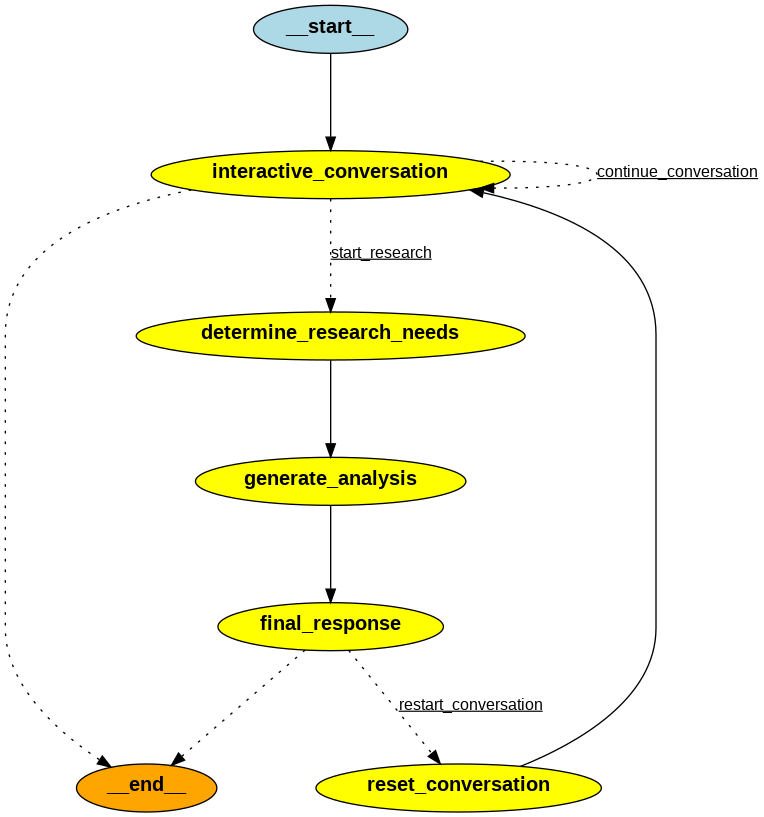

In [ ]:
# === Build the Multi-Turn Graph (Revised Edges) ===

graph_builder = StateGraph(State)

# Add nodes (NO wait_for_user node)
graph_builder.add_node("interactive_conversation", interactive_conversation)
# graph_builder.add_node("wait_for_user", wait_for_user_response) # REMOVED
graph_builder.add_node("determine_research_needs", determine_research_needs)
graph_builder.add_node("generate_analysis", generate_analysis)
graph_builder.add_node("final_response", final_response)
graph_builder.add_node("reset_conversation", reset_conversation)

# Starting edge
graph_builder.add_edge(START, "interactive_conversation")

# Edges from interactive_conversation based on determine_next_stage
graph_builder.add_conditional_edges(
    "interactive_conversation",
    determine_next_stage,
    {
        "continue_conversation": "interactive_conversation", # Loop back if user responded
        "start_research": "determine_research_needs",       # Move to research when ready
        END: END                                            # Route to graph's END when yielding for user
    }
)

# REMOVED Edges related to wait_for_user

# Connect research and analysis flow (remains the same)
graph_builder.add_edge("determine_research_needs", "generate_analysis")
graph_builder.add_edge("generate_analysis", "final_response")

# End after final response (or handle reset/follow-up from there)
graph_builder.add_conditional_edges(
    "final_response",
    determine_next_stage, # Reuse determine stage after final report is added
    {
        END: END, # Use END directly to terminate graph execution
        "restart_conversation": "reset_conversation"
    }
)

# Connect reset node back to conversation (remains the same)
graph_builder.add_edge("reset_conversation", "interactive_conversation")

# Compile the graph
print("Compiling the revised graph...")
graph = graph_builder.compile()
print("Revised graph compiled.")

#Optional: Draw the graph again if you like
from IPython.display import Image
try:
    display(Image(graph.get_graph().draw_png()))
except Exception as e:
    print(f"Could not draw graph: {e}")

In [ ]:
# !apt-get install -y graphviz graphviz-dev
# !pip install pygraphviz
# from IPython.display import Image
# display(Image(graph.get_graph().draw_png()))

In [ ]:
# System Prompt
# Defines AI's role and responsibilities in medical analysis
SYSTEM_PROMPT = """You are an advanced AI medical assistant with access to up-to-date medical literature, expert guidelines, and peer-reviewed studies. Your role is to:
1. Conduct a structured diagnostic evaluation, mimicking a board-certified physician’s approach.
2. Use differential diagnosis methods, listing probable conditions with confidence scores.
3. Prioritize high-accuracy, medically reviewed sources (such as but not limited to PubMed, Mayo Clinic, NIH, UpToDate).
4. Clearly communicate **when emergency medical care might be required**.
5. Provide structured medical reports with citations, risk assessments, and next steps.
"""

In [ ]:
# Execution Function
# Main function to run the medical analysis workflow
def run_medical_analysis(initial_message: str):
    """Runs the medical analysis graph with the given initial message."""
    initial_state = {
        "messages": [{"role": "user", "content": initial_message}],
        "research_results": {},
        "analysis_complete": False,
        "report": {}
    }

    results = graph.invoke(initial_state)
    return results["messages"]

In [ ]:
#Let's put the model to test!
# Test cases with different symptoms
sample_input = "Hi, I've been feeling really off lately. " \
"For the past few hours, I’ve had some chest discomfort, " \
"but it’s not exactly pain. It’s more of a pressure, kind of like " \
"something heavy is on my chest. I also feel really short of breath, " \
"especially when I try to move around or even just stand up. Sometimes, it " \
"feels like my left arm is a little sore, and I've noticed some dizziness as well. " \
"I’m also feeling unusually nauseous, which isn’t something I usually deal with. " \
"I’m 45, not very active, and have had some family members with heart issues. " \
"I’m not sure if this is something I should be concerned about or if I’m just " \
"overthinking it. Can you help?"

In [ ]:
# === Interactive Command Line Execution (with Rich Rendering) ===

# Make sure these imports are accessible here
from rich.console import Console
from rich.markdown import Markdown

def run_command_line():
    """Run an interactive demo of the medical chatbot in the command line."""
    print("\n--- Medical Symptom Analysis Chatbot ---")
    print("Describe your symptoms to start.")
    print("Type 'exit' to end.")
    print("Type 'new topic' (or similar) after analysis to discuss something else.\n")

    # Instantiate Console *outside* the loop
    console = Console()
    state = None # Initialize state

    while True:
        if not state:
            # Start of a new conversation
            user_input = input("You: ")
            if user_input.lower() == 'exit':
                break
            initial_state_dict = {
                "messages": [{"role": "user", "content": user_input}],
                "research_results": {}, "analysis_complete": False, "report": {},
                "conversation_stage": "conversation", "symptom_details": {}, "question_count": 0
            }
            # Invoke the graph to get the first assistant response
            try:
                print("DEBUG: Invoking graph (initial)...")
                state = graph.invoke(initial_state_dict, {"recursion_limit": 15})
                print("DEBUG: Graph invocation complete (initial).")
            except Exception as e:
                # Use console.print for error messages too, for consistency
                console.print(f"\n[bold red]ERROR:[/bold red] Graph failed during initial invocation: {e}")
                console.print("Please try again or type 'exit'.")
                state = None
                continue

        else:
            # Continue existing conversation
            user_input = input("You: ")
            if user_input.lower() == 'exit':
                break

            current_messages = state.get("messages", [])
            updated_messages = current_messages + [{"role": "user", "content": user_input}]
            state["messages"] = updated_messages

            try:
                print("DEBUG: Invoking graph (continue)...")
                state = graph.invoke(state, {"recursion_limit": 15})
                print("DEBUG: Graph invocation complete (continue).")
            except Exception as e:
                console.print(f"\n[bold red]ERROR:[/bold red] Graph failed during continuation: {e}")
                if state and state.get("messages"):
                     # Try to render the last assistant message before the error, if possible
                     last_assistant_message = state["messages"][-1]
                     if last_assistant_message.get("role") == "assistant":
                         console.print(f"\n[bold deep_sky_blue1][Assistant]:[/bold deep_sky_blue1]")
                         console.print(Markdown(last_assistant_message.get('content', '[No Content]')))
                     else: # Fallback if last message wasn't assistant
                         console.print("\n[bold red]Assistant:[/bold red] Sorry, an error occurred.")
                else:
                    console.print("\n[bold red]Assistant:[/bold red] Sorry, an error occurred and I lost track of the conversation. Please start over or type 'exit'.")
                    state = None
                continue


        # --- Process graph output ---
        if not state or not state.get("messages"):
            console.print("\n[bold red]Assistant:[/bold red] Sorry, something went wrong, and I don't have a response.")
            state = None
            continue

        # Display the latest assistant message using Rich
        assistant_message = state["messages"][-1]
        if assistant_message.get("role") == "assistant":
            # *** Use Rich Console and Markdown Here ***
            console.print(f"\n[bold deep_sky_blue1][Assistant]:[/bold deep_sky_blue1]")
            markdown_content = Markdown(assistant_message.get('content', '[No Content]'))
            console.print(markdown_content)
            print() # Add an extra newline for spacing after the rendered block
        else:
            # Should not happen if graph works correctly
            print("DEBUG: Expected assistant message, but last message was:", assistant_message.get("role"))


        # Check if the conversation has reached a final state
        current_stage = state.get("conversation_stage")
        if current_stage == "complete":
            if "--- End of Report ---" in str(assistant_message.get("content", "")):
                # Use console.print for consistency
                console.print("\n[bold green]--- Analysis Complete ---[/bold green]")
                console.print("You can ask follow-up questions about this report, type 'new topic' to discuss something else, or type 'exit'.")
            else:
                console.print("\n[bold yellow]--- Conversation Ended ---[/bold yellow]")
                break # Exit loop


    console.print("\nChat ended.")

# --- Optional: Helper for running in Colab ---
# (Keep start_interactive_chat as is, it just calls the modified run_command_line)
def start_interactive_chat():
    try:
        if not GEMINI_API_KEY or not PERPLEXITY_API_KEY:
             print("ERROR: API Keys not found. Please set them up in Colab secrets.")
             return
        run_command_line() # This now uses the rich-enabled version
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Start the interactive chat session
# start_interactive_chat() # Call this to run

We have the components and the graph blueprint. Now let's run it!

In [ ]:
start_interactive_chat()


--- Medical Symptom Analysis Chatbot ---
Describe your symptoms to start.
Type 'exit' to end.
Type 'new topic' (or similar) after analysis to discuss something else.

You: input_1 = "Hey doc, I’ve been super drained lately — like barely getting out of bed kinda tired. It's been going on for maybe two weeks now? Just always wiped out, even after sleeping a lot."
DEBUG: Invoking graph (initial)...
DEBUG: Entering interactive_conversation node...
DEBUG: (interactive_conversation) Extracting details from latest user message...
DEBUG: Extracting symptom details...
DEBUG: Symptom extraction complete.
DEBUG: Invoking LLM for conversation (Turn 1, assessing sufficiency, expecting JSON)...
DEBUG: LLM raw response received: '```json
{
  "proceed_to_research": false,
  "assistant_message": "Can you describe what you mean by 'sleeping a lot'? How many hours per night are you sleeping?" 
}
```...'
DEBUG: JSON parsed successfully. proceed_to_research=False
DEBUG: Based on parsed JSON/error handling

[Assistant]:

Can you describe what you mean by 'sleeping a lot'? How many hours per night are you sleeping?


You: "Yeah, like 10-11 hours most nights, sometimes more if I take a nap during the day too. But even then, I wake up feeling foggy and still exhausted."
DEBUG: Invoking graph (continue)...
DEBUG: Entering interactive_conversation node...
DEBUG: (interactive_conversation) Extracting details from latest user message...
DEBUG: Extracting symptom details...
DEBUG: Symptom extraction complete.
DEBUG: Invoking LLM for conversation (Turn 2, assessing sufficiency, expecting JSON)...
DEBUG: LLM raw response received: '```json
{
  "proceed_to_research": false,
  "assistant_message": "Have you experienced any other symptoms, such as fever, chills, weight changes, or changes in bowel habits?" 
}
```...'
DEBUG: JSON parsed successfully. proceed_to_research=False
DEBUG: Based on parsed JSON/error handling: enough info? False. New stage: conversation
DEBUG: Determining next stage... Current stage: conversation
DEBUG: Routing to END (yielding for user input).
DEBUG: Graph invocation complete (contin

[Assistant]:

Have you experienced any other symptoms, such as fever, chills, weight changes, or changes in bowel habits?


You: "Yeah actually, I’ve had this low-grade fever off and on. Nothing super high — like 100 to 100.5 maybe — and some chills here and there. Appetite’s been kinda meh too. Haven’t really lost weight, but food just doesn’t sound that good lately."
DEBUG: Invoking graph (continue)...
DEBUG: Entering interactive_conversation node...
DEBUG: (interactive_conversation) Extracting details from latest user message...
DEBUG: Extracting symptom details...
DEBUG: Symptom extraction complete.
DEBUG: Invoking LLM for conversation (Turn 3, assessing sufficiency, expecting JSON)...
DEBUG: LLM raw response received: '```json
{
  "proceed_to_research": false,
  "assistant_message": "Have you noticed any swollen lymph nodes, particularly in your neck or armpits?"
}
```...'
DEBUG: JSON parsed successfully. proceed_to_research=False
DEBUG: Based on parsed JSON/error handling: enough info? False. New stage: conversation
DEBUG: Determining next stage... Current stage: conversation
DEBUG: Routing to END (y

[Assistant]:

Have you noticed any swollen lymph nodes, particularly in your neck or armpits?


You: "Yeah, now that you mention it — I did feel a couple of tender lumps under my jaw last week. I thought it was just from clenching my teeth or something. They’re not huge or anything, but kinda sore if I press on them. Nothing in my armpits that I’ve noticed though."
DEBUG: Invoking graph (continue)...
DEBUG: Entering interactive_conversation node...
DEBUG: (interactive_conversation) Extracting details from latest user message...
DEBUG: Extracting symptom details...
DEBUG: Symptom extraction complete.
DEBUG: Invoking LLM for conversation (Turn 4, assessing sufficiency, expecting JSON)...
DEBUG: LLM raw response received: '```json
{
  "proceed_to_research": false,
  "assistant_message": "Have you had any recent travel, especially internationally?"
}
```...'
DEBUG: JSON parsed successfully. proceed_to_research=False
DEBUG: Based on parsed JSON/error handling: enough info? False. New stage: conversation
DEBUG: Determining next stage... Current stage: conversation
DEBUG: Routing to EN

[Assistant]:

Have you had any recent travel, especially internationally?


You: "No, I haven’t traveled recently, at least not outside the country. I did go camping a couple of weekends ago, but no other trips or anything."
DEBUG: Invoking graph (continue)...
DEBUG: Entering interactive_conversation node...
DEBUG: (interactive_conversation) Extracting details from latest user message...
DEBUG: Extracting symptom details...
DEBUG: Symptom extraction complete.
DEBUG: Invoking LLM for conversation (Turn 5, assessing sufficiency, expecting JSON)...
DEBUG: LLM raw response received: '```json
{
  "proceed_to_research": true,
  "assistant_message": "Okay, proceeding to analysis." 
}
``` ...'
DEBUG: JSON parsed successfully. proceed_to_research=True
DEBUG: Based on parsed JSON/error handling: enough info? True. New stage: research
DEBUG: Determining next stage... Current stage: research
DEBUG: Routing to start_research.
DEBUG: Entering determine_research_needs node...
DEBUG: Using extracted symptom details for research prompt.
RESPONSE: Starting Perplexity research.

[Assistant]:

--- Medical Analysis Report ---                                                                                    

                                                                                                                   
 ## Medical Analysis Report: Fatigue and Lymphadenopathy                                                           
                                                                                                                   
 **Date:** October 26, 2023                                                                                        
                                                                                                                   
 **Patient Presentation:** A patient presents with severe fatigue of two weeks duration, intermittent low-grade    
 fever (100-100.5°F), excessive sleep (10-11 hours/night plus naps), brain fog, decreased appetite, and tender lum 
 under the jaw.  The patient recently returned from a domestic camping trip.                                       
                                                                                                                   
 **1. Summary of Key Symptoms and Risk Factors:**                                                                  
                                                                                                                   
 * **Key Symptoms:** Severe fatigue (2 weeks), intermittent low-grade fever, excessive sleep, brain fog, decreased 
 appetite, tender cervical lymphadenopathy.                                                                        
 * **Risk Factors:** Recent camping trip (potential exposure to various pathogens).  No recent international trave 
                                                                                                                   
                                                                                                                   
 **2. Differential Diagnosis (Ranked with Confidence Scores):**                                                    
                                                                                                                   
 Based on the presented symptoms and risk factors, the following differential diagnosis is proposed:               
                                                                                                                   
 | Condition                     | Confidence Score | Justification                                                
 |                                                                                                                 
 |---------------------------------|-------------------|---------------------------------------------------------- 
 ---------------------------------------------------------------------------------|                                
 | Infectious Mononucleosis (Mono) | 85%               | Classic presentation of fatigue, fever, and cervical      
 lymphadenopathy in a young adult,[38;2;248;24

--- Analysis Complete ---

You can ask follow-up questions about this report, type 'new topic' to discuss something else, or type 'exit'.

You: exit


Chat ended.

# Workshop Recap

Congratulations! You've built and interacted with a multi-step AI agent using LangGraph.

**Key Takeaways:**

* **LLMs can orchestrate:** They don't just generate text; they can follow steps, use tools, and make autonomous decisions within a defined structure.
* **LangGraph provides structure:** It allows us to build complex, stateful AI workflows reliably by defining nodes (steps) and edges (transitions).
* **State is crucial:** Managing the conversation history, intermediate results, and current stage is essential for multi-turn interactions for complex tasks.
* **Tools enhance LLMs:** Giving LLMs access to external APIs or functions dramatically increases their capabilities, making them experts at tasks.
* **Prompting is key:** Carefully crafted prompts (System prompts, prompts for nodes. tools) guide the AI's behavior.

**Further Exploration:**

* Add more tools (e.g., a calculator, a database lookup).
* Experiment with different LLMs or prompt strategies on new use cases.
* Explore LangSmith for debugging and tracing your graph runs.